In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
data = pd.read_table('coord.txt', delimiter='\t')
tr_dict = pd.read_table('two_RNAs.txt', delimiter='\t')

In [3]:
def rename_idx(idx_name):
    global tr_dict
    new_name = tr_dict[tr_dict['New_Structure'] == idx_name].index.to_list()[0]
    tr_dict = tr_dict.drop(index=[new_name])
    return new_name

In [4]:
duplicates_idx = []
for i in data.index:
    if len(tr_dict[tr_dict['New_Structure'] == i].index.to_list()) == 0:
        duplicates_idx.append(i)

In [5]:
for idx in duplicates_idx:
    data = data.drop(index = [idx])

In [6]:
data.index = data.index.map(rename_idx)

In [7]:
#data.to_csv(r'new_coord.txt', sep='\t')

In [8]:
data.loc[data['as.factor.gene_marks.'] == 'red', 'comment'] = 'Experimentaly_verified'
data.loc[data['as.factor.gene_marks.'] == 'blue', 'comment'] = 'Predicted_transcripts'
data.loc[data['comment'] == 'Experimentaly_verified', 'p_distance_to_center'] = 100
data.loc[data['comment'] == 'Experimentaly_verified', 'p_distance_to_nearest'] = 100
data.loc[data['comment'] == 'Experimentaly_verified', 'p_avg_distance_k-confirmed'] = 100

In [9]:
# distances = pdist(data[['Axis.1', 'Axis.2']], metric='euclidean')
distances = pdist(data.loc[:, 'Axis.1':'Axis.27'], metric='euclidean')
# dist_matrix = squareform(distances)

In [10]:
full_diametr = distances.max()
full_diametr

1.064274084531275

In [11]:
center_point_df = pd.DataFrame(data.loc['RUNX1-RUNX1T1_[I.001]', 'Axis.1':'Axis.27']).T

learning_rate = 0.1

for i in range(1000):
    for idx in data[data['comment'] == 'Experimentaly_verified'].index.to_list():
        center_point_df = center_point_df.loc[:, 'Axis.1':'Axis.27'] + learning_rate * (data.loc[idx, 'Axis.1':'Axis.27'] - center_point_df.loc[:, 'Axis.1':'Axis.27'])
    
center_point_df

,Axis.1,Axis.2,Axis.3,Axis.4,Axis.5,Axis.6,Axis.7,Axis.8,Axis.9,Axis.10,...,Axis.18,Axis.19,Axis.20,Axis.21,Axis.22,Axis.23,Axis.24,Axis.25,Axis.26,Axis.27
RUNX1-RUNX1T1_[I.001],-0.0357736,-0.18064,0.184272,0.0175179,-0.00988951,0.00356852,0.0303543,-0.118047,-0.11566,-0.0196862,...,-0.0122195,0.0196333,0.0287705,-0.0113045,0.0123996,0.000184607,-0.007957,0.000857244,-0.00431878,-0.000368035


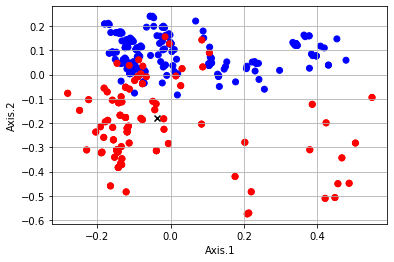

In [12]:
fig, ax = plt.subplots()
ax.scatter(x = data['Axis.1'], y = data['Axis.2'], c = data['as.factor.gene_marks.'])
ax.scatter(x = data[data['comment'] == 'Experimentaly_verified']['Axis.1'], y = data[data['comment'] == 'Experimentaly_verified']['Axis.2'], c = data[data['comment'] == 'Experimentaly_verified']['as.factor.gene_marks.'])
plt.grid(True)
plt.xlabel("Axis.1")
plt.ylabel("Axis.2")

ax.scatter(x = center_point_df['Axis.1'], y = center_point_df['Axis.2'], c = 'black', marker = 'x')

plt.show()

In [13]:
def suitability_probability(full_diametr, d):
    return 100 * (1 - d / full_diametr)

In [14]:
center_point = np.array(center_point_df.loc[:, :])

In [15]:
# distance to center
for idx in data[data['comment'] == 'Predicted_transcripts'].index.to_list():
    point = np.array(data.loc[idx, 'Axis.1':'Axis.27'])
    d = np.linalg.norm(center_point - point)
    data.at[idx, 'p_distance_to_center'] = suitability_probability(full_diametr, d)

In [16]:
# distance to nearest
for idx_pr in data[data['comment'] == 'Predicted_transcripts'].index.to_list():
    d = full_diametr
    point_pr = np.array(data.loc[idx_pr, 'Axis.1':'Axis.27'])
    for idx_vf in data[data['comment'] == 'Experimentaly_verified'].index.to_list():
        point_vf = np.array(data.loc[idx_vf, 'Axis.1':'Axis.27'])
        d = min(np.linalg.norm(point_pr - point_vf), d)
    data.at[idx_pr, 'p_distance_to_nearest'] = suitability_probability(full_diametr, d)

In [17]:
# avg distance to k-confirmed
k = 97
counter_k = 0

avg_dist = 0

for idx_pr in data[data['comment'] == 'Predicted_transcripts'].index.to_list():
    point_pr = np.array(data.loc[idx_pr, 'Axis.1':'Axis.27'])
    for idx_vf in data[data['comment'] == 'Experimentaly_verified'].index.to_list():
        point_vf = np.array(data.loc[idx_vf, 'Axis.1':'Axis.27'])
        avg_dist += np.linalg.norm(point_pr - point_vf)
        counter_k += 1
        if counter_k == k:
            break
    
    d = avg_dist / counter_k
    data.at[idx_pr, 'p_avg_distance_k-confirmed'] = suitability_probability(full_diametr, d)

In [18]:
data[data['comment'] == 'Predicted_transcripts'].loc[:, 'p_distance_to_center':'p_avg_distance_k-confirmed'].sort_values(by='p_distance_to_center', ascending=True)

,p_distance_to_center,p_distance_to_nearest,p_avg_distance_k-confirmed
Tr_01364,20.422694,37.945776,40.734741
Tr_01302,25.210592,41.470641,41.076300
Tr_01240,26.442857,44.115784,41.435883
Tr_00695,27.347398,46.294955,41.415079
Tr_00001,27.890918,48.188460,22.965868
...,...,...,...
Tr_00206,60.952108,77.719039,40.962185
Tr_00022,61.018594,83.809918,40.886545
Tr_00207,62.004968,100.000000,41.206817
Tr_00214,62.004968,100.000000,41.594019
